# MORE EFFICIENT PORTFOLIO ALLOCATION WITH QUASI-MONTE CARLO METHODS USING QMCPY
Larysa Matiukha and Sou-Cheng T. Choi

Illinois Institute of Technology

Modification date: 12/21/2025

In [ ]:
try:
    import qmcpy as qp 
except ModuleNotFoundError:
    !pip install -q qmcpy

In [1]:
import qmcpy as qp
import pandas as pd
import numpy as np

try:
    import yfinance as yf
except ImportError:
    !pip install -q yfinance
    import yfinance as yf

import seaborn as sn
import matplotlib.pyplot as plt
import time

# from scipy.optimize import minimize
import timeit

from pathlib import Path

sn.set_style('whitegrid')
plt.rcParams['grid.alpha'] = 0.3
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 10

In [2]:
# make folders `data` and `images`
import os
data_dir = 'data' + os.sep
# images_dir = 'images' + os.sep
if not os.path.exists('data'):
    os.makedirs(data_dir)
# if not os.path.exists('images'):
#     os.makedirs(images_dir)

*Portfolio allocation* is a strategic process that aims to balance risk and return by distributing funds among diverse assets with varying risks and returns [5]. The goal is to create a diversified portfolio that can mitigate risk and  enhance returns over time, while  reducing the impact of market changes on individual assets. In this study for portfolio allocation, utilizing the open-source QMCPy library[2,3], we apply quasi-Monte Carlo methods in the distribution of funds among individual stocks in a portfolio.

In [3]:
start_date = '2014-01-01'
end_date = '2025-12-13'

In [26]:
# Define tickers
tickers = ["AAPL", "AMZN", "CSCO", "IBM"]
tickers1 = ["AAPL", "AMZN", "CSCO", "IBM", "TSLA", "META", "ABNB", "UPS", "NFLX", "MRNA"]
tickers2 = ["AAPL", "AMZN", "CSCO","IBM","TSLA","META","ABNB","UPS","NFLX","MRNA","^IXIC", "T","GE","FMC","AMC","JPM","DIS","CVX","GOOGL","BA"]

In [5]:
# Define sampler types and visualization parameters
sampler_types = ['iid', 'lattice', 'sobol', 'halton']
colors = ['magenta', 'indigo', 'limegreen', 'blue']
markers = ['D', 'o', 's', '^']

# Map sampler types to QMCPy classes
sampler_classes = {
    'lattice': qp.Lattice,
    'sobol': qp.Sobol,
    'halton': qp.Halton,
    'iid': qp.IIDStdUniform
}

# Generating Portfolio Weights

We implement functions to generate portfolio weights using different sampling methods:
- **Lattice** (QMC) — Low-discrepancy sequence with good space-filling properties
- **Sobol** (QMC) — Another low-discrepancy sequence, popular in finance
- **Halton** (QMC) — Low-discrepancy sequence based on prime bases
- **IID** (MC) — Traditional Monte Carlo with pseudo-random uniform samples

The weights are normalized to sum to 1 for each portfolio (simplex constraint).

In [7]:
def gen_weights_reps(sampler_type, n_tickers, n_ports, replications=1, seed=42):
    """
    Generate portfolio weights with replications using specified sampling method.
    
    Parameters:
        sampler_type: str - 'lattice', 'sobol', 'halton', or 'iid'
        n_tickers: int - number of assets (dimension)
        n_ports: int - number of portfolios per replication
        replications: int - number of replications
        seed: int - random seed for reproducibility
    
    Returns:
        weights: ndarray of shape (replications, n_ports, n_tickers) with rows summing to 1
    """
    if sampler_type not in sampler_classes:
        raise ValueError(f"Unknown sampler type: {sampler_type}. Must be one of {list(sampler_classes.keys())}")
    
    sampler = sampler_classes[sampler_type](dimension=n_tickers, replications=replications, seed=seed)
    weights = sampler.gen_samples(n_ports)
    
    # Normalize weights to sum to 1 (simplex projection)
    weights /= weights.sum(axis=2, keepdims=True)
    return weights

## Risk-free rates

In [8]:
rf = pd.read_csv("data/rf_annual_2014-01-01_to_2025-12-13.csv", index_col=0, parse_dates=True).dropna()
rf_avg = rf.mean().iloc[0] # compute mean

## Computing Sharpe Ratio
Sharpe Ratio is given by: $(R_P - R_F)/V$, where $R_F$ is risk-free rates,  $R_P = \sum_{i=1}^{d} R_iw_i$ stands for the excess expected return of a portfolio and $V = \sqrt{\sum_{i=1}^{d} \sum_{j=1}^{d} \sigma_{ij} w_i w_j}$ represents  its expected volatility with $d$ number of assets in a portfolio, weights $w_i$'s, and covariance of assets $i$ and $j$ $\sigma_{ij}$

In [9]:
def sharpe_reps(weights, log_ret, log_rf_avg=None):
    """Compute Sharpe ratios for portfolios at three risk levels."""
    
    R, P, D = weights.shape

    # Expected return
    ret_arr = np.sum(weights * log_ret.mean().values * 252, axis=2)

    # Expected volatility
    vol_arr = np.sqrt(np.sum(weights @ (log_ret.cov().values * 252) * weights, axis=2))

    # Sharpe Ratio
    if log_rf_avg is None:
        sharpe_arr = ret_arr / vol_arr # without risk-free rate
    else:
        #log_rf_avg = log_rf.mean() # Risk-free rate
        sharpe_arr = (ret_arr - log_rf_avg) / vol_arr 

    low_risk_weights, medium_risk_weights, high_risk_weights = [], [], []
    low_risk_max_sharpe, medium_risk_max_sharpe, high_risk_max_sharpe = [], [], []

    for r in range(R):
        vol_r = vol_arr[r]
        sharpe_r = sharpe_arr[r]

        low_risk_tolerance = np.quantile(vol_r, 1/3)
        medium_risk_tolerance = np.quantile(vol_r, 2/3)

        low_risk_idx_arr = np.where(vol_r <= low_risk_tolerance)[0]
        medium_risk_idx_arr = np.where((vol_r > low_risk_tolerance) & (vol_r <= medium_risk_tolerance))[0]

        high_risk_idx = np.argmax(sharpe_r)
        medium_risk_idx = medium_risk_idx_arr[np.argmax(sharpe_r[medium_risk_idx_arr])]
        low_risk_idx = low_risk_idx_arr[np.argmax(sharpe_r[low_risk_idx_arr])]

        # ratios
        low_risk_max_sharpe.append(sharpe_r[low_risk_idx])
        medium_risk_max_sharpe.append(sharpe_r[medium_risk_idx])
        high_risk_max_sharpe.append(sharpe_r[high_risk_idx])

        # weights 
        low_risk_weights.append(weights[r, low_risk_idx])
        medium_risk_weights.append(weights[r, medium_risk_idx])
        high_risk_weights.append(weights[r, high_risk_idx])

    return {
        "number of tickers": D,
        "number of portfolios": P,
        "replications": R,

        "low": np.array(low_risk_weights),
        "medium": np.array(medium_risk_weights),
        "high": np.array(high_risk_weights),

        "low risk Sharpe": np.round(np.mean(low_risk_max_sharpe), 3),
        "medium risk Sharpe": np.round(np.mean(medium_risk_max_sharpe), 3),
        "high risk Sharpe": np.round(np.mean(high_risk_max_sharpe), 3),
    }


In [10]:
def evaluate_sampler_sharpe_reps(sampler_type, log_ret, n_ports, replications, log_rf = None):
    
    n_tickers = log_ret.shape[1]
    rows = []

    for ports in n_ports:
        weights = gen_weights_reps(sampler_type, n_tickers, ports, replications)
        sr = sharpe_reps(weights, log_ret, log_rf)

        rows.append({
            'sampler': sampler_type,
            'number of tickers': n_tickers,
            'number of portfolios': ports,
            'replications': replications,
            'low risk Sharpe': sr['low risk Sharpe'],
            'medium risk Sharpe': sr['medium risk Sharpe'],
            'high risk Sharpe': sr['high risk Sharpe'],
        })

    return pd.DataFrame(rows)
    
def evaluate_all_samplers(lr, n_ports, log_rf = None, replications=30):
    """Evaluate all samplers (replicated) for given log returns"""
    dfs = [evaluate_sampler_sharpe_reps(st, lr, n_ports, replications, log_rf) for st in sampler_types]
    return pd.concat(dfs, ignore_index=True)


# Evaluating Sharpe ratios
We compare different sampling methods by computing Sharpe ratios at multiple
risk levels using portfolio weights generated by each method. For each sampler,
Sharpe ratios are computed across multiple replications, and the presented
results are averaged for low-, medium-, and high-risk strategies. We include Sharpe ratios computed with and without risk-free rate.


## Evaluating Sharpe ratios for four tickers
First, we evaluate Sharpe ratios for portfolios consisting of four assets:
AAPL, AMZN, CSCO, and IBM.

In [11]:
lr = pd.read_csv("data/log_returns_2014-01-01_to_2025-12-13.csv", index_col=0, parse_dates=True)
n_ports = [2**13, 2**14, 2**15]

results = evaluate_all_samplers(lr, n_ports)
results

,sampler,number of tickers,number of portfolios,replications,low risk Sharpe,medium risk Sharpe,high risk Sharpe
0,iid,4,8192,50,0.807,0.838,0.859
1,iid,4,16384,50,0.807,0.838,0.859
2,iid,4,32768,50,0.808,0.838,0.859
3,lattice,4,8192,50,0.807,0.838,0.859
4,lattice,4,16384,50,0.808,0.838,0.859
5,lattice,4,32768,50,0.808,0.838,0.859
6,sobol,4,8192,50,0.807,0.838,0.859
7,sobol,4,16384,50,0.808,0.838,0.859
8,sobol,4,32768,50,0.808,0.838,0.859
9,halton,4,8192,50,0.807,0.838,0.859


In [12]:
results_rf = evaluate_all_samplers(lr, n_ports, rf_avg) # with risk-free rates 
results_rf

,sampler,number of tickers,number of portfolios,replications,low risk Sharpe,medium risk Sharpe,high risk Sharpe
0,iid,4,8192,50,0.723,0.757,0.788
1,iid,4,16384,50,0.723,0.758,0.788
2,iid,4,32768,50,0.723,0.758,0.788
3,lattice,4,8192,50,0.723,0.757,0.788
4,lattice,4,16384,50,0.723,0.758,0.788
5,lattice,4,32768,50,0.724,0.758,0.788
6,sobol,4,8192,50,0.723,0.757,0.788
7,sobol,4,16384,50,0.723,0.757,0.788
8,sobol,4,32768,50,0.724,0.758,0.788
9,halton,4,8192,50,0.723,0.757,0.788


## Evaluating Sharpe ratios with lattice weights for ten tickers

We repeat the analysis using ten assets to investigate how the sampling methods behave
as the portfolio dimension increases, while keeping the number of portfolios
fixed.


In [13]:
# tickers1 = ["AAPL", "AMZN", "CSCO", "IBM", "TSLA", "META", "ABNB", "UPS", "NFLX", "MRNA"]
# description1 = ["Apple", "Amazon", "CISCO", "IBM", "Tesla", "Meta", "Airbnb", "UPS", "Netflix", "Moderna"]

lr1 = pd.read_csv("data/log_returns10_2014-01-01_to_2025-12-13.csv", index_col=0, parse_dates=True)
n_ports = [2**13, 2**14, 2**15]

results_10t = evaluate_all_samplers(lr1, n_ports)
results_10t 

,sampler,number of tickers,number of portfolios,replications,low risk Sharpe,medium risk Sharpe,high risk Sharpe
0,iid,10,8192,50,0.712,0.606,0.712
1,iid,10,16384,50,0.730,0.617,0.730
2,iid,10,32768,50,0.755,0.629,0.755
3,lattice,10,8192,50,0.723,0.604,0.723
4,lattice,10,16384,50,0.736,0.617,0.736
5,lattice,10,32768,50,0.757,0.627,0.757
6,sobol,10,8192,50,0.725,0.604,0.725
7,sobol,10,16384,50,0.750,0.614,0.750
8,sobol,10,32768,50,0.765,0.626,0.765
9,halton,10,8192,50,0.733,0.607,0.733


In [14]:
results_10t_rf = evaluate_all_samplers(lr1, n_ports, rf_avg)
results_10t_rf

,sampler,number of tickers,number of portfolios,replications,low risk Sharpe,medium risk Sharpe,high risk Sharpe
0,iid,10,8192,50,0.627,0.536,0.627
1,iid,10,16384,50,0.645,0.547,0.645
2,iid,10,32768,50,0.669,0.559,0.669
3,lattice,10,8192,50,0.639,0.534,0.639
4,lattice,10,16384,50,0.651,0.547,0.651
5,lattice,10,32768,50,0.671,0.557,0.671
6,sobol,10,8192,50,0.640,0.534,0.640
7,sobol,10,16384,50,0.664,0.544,0.664
8,sobol,10,32768,50,0.678,0.557,0.678
9,halton,10,8192,50,0.649,0.537,0.649



## Evaluating Sharpe ratios  for twenty tickers
Finally, we extend the analysis to twenty assets to further study the impactof dimensionality on the resulting Sharpe ratios.


In [15]:
# tickers2 = ["AAPL", "AMZN", "CSCO","IBM","TSLA","META","ABNB","UPS","NFLX","MRNA","^IXIC", "T","GE","FMC","AMC","JPM","DIS","CVX","GOOGL","BA"]
# description2 = ["Apple", "Amazon", "CISCO", "IBM","Tesla","Meta","Airbnb","UPS","Netflix","Moderna","NASDAQ","AT&T","General Electric","FMC","AMC","JPMorgan","Disney","Chevron","Google","Boeing"]

lr2 = pd.read_csv("data/log_returns20_2014-01-01_to_2025-12-13.csv", index_col=0, parse_dates=True)
n_ports = [2**13, 2**14, 2**15]

results_20t = evaluate_all_samplers(lr2, n_ports)
results_20t 

,sampler,number of tickers,number of portfolios,replications,low risk Sharpe,medium risk Sharpe,high risk Sharpe
0,iid,20,8192,50,0.712,0.581,0.712
1,iid,20,16384,50,0.733,0.600,0.733
2,iid,20,32768,50,0.757,0.626,0.757
3,lattice,20,8192,50,0.717,0.578,0.717
4,lattice,20,16384,50,0.737,0.600,0.737
5,lattice,20,32768,50,0.759,0.620,0.759
6,sobol,20,8192,50,0.722,0.589,0.722
7,sobol,20,16384,50,0.734,0.608,0.734
8,sobol,20,32768,50,0.753,0.627,0.753
9,halton,20,8192,50,0.711,0.580,0.711


In [16]:
results_20t_rf = evaluate_all_samplers(lr2, n_ports, rf_avg)
results_20t_rf

,sampler,number of tickers,number of portfolios,replications,low risk Sharpe,medium risk Sharpe,high risk Sharpe
0,iid,20,8192,50,0.621,0.501,0.622
1,iid,20,16384,50,0.642,0.521,0.642
2,iid,20,32768,50,0.665,0.546,0.665
3,lattice,20,8192,50,0.626,0.499,0.626
4,lattice,20,16384,50,0.646,0.520,0.646
5,lattice,20,32768,50,0.667,0.540,0.667
6,sobol,20,8192,50,0.630,0.509,0.630
7,sobol,20,16384,50,0.642,0.528,0.642
8,sobol,20,32768,50,0.661,0.547,0.661
9,halton,20,8192,50,0.620,0.500,0.620


# Runtime comparison

We compare the computational cost of all sampling methods by measuring the
runtime required to generate portfolio weights. We measure both real (wall-clock) and CPU time and consider two 
scalability experiments:

1. **Runtime vs number of tickers (dimension)** with a fixed number of portfolios.
2. **Runtime vs number of portfolios (samples)** with a fixed number of tickers.

All timings are averaged over multiple runs to reduce noise.

In [17]:
def measure_runtime():
    """Measure runtime for QMC and MC samplers."""
    # Experiment configurations
    sampler_types = ['lattice', 'sobol', 'halton', 'iid']
    dimensions = [5, 10, 20, 50, 100, 200, 500, 1000]
    num_samples = [2**m for m in range(8, 18)] # 256 to 131072
    fixed_dimension = 50
    fixed_num_samples = 2**12
    repeats = 3

    results = []

    for sampler in sampler_types:

        # Runtime vs dimension
        for d in dimensions:
            try:
                start_cpu = time.process_time()
                t_real = timeit.timeit(
                    lambda: gen_weights(sampler, d, fixed_num_samples),
                    number=repeats
                ) / repeats
                end_cpu = time.process_time()
                t_cpu = (end_cpu - start_cpu) / repeats

            except Exception as e:
                print(f"Skipping sampler={sampler} dim={d}: {e}")
                t_real = float('nan')
                t_cpu = float('nan')

            results.append({
                'Series': 'Tickers',
                'Sampler': sampler,
                'Tickers': d,
                'Portfolios': fixed_num_samples,
                'Runtime_real': t_real,
                'Runtime_CPU': t_cpu
            })


        # Runtime vs samples
        for n in num_samples:
            try:
                start_cpu = time.process_time()
                t_real = timeit.timeit(
                    lambda: gen_weights(sampler, fixed_dimension, n),
                    number=repeats
                ) / repeats
                end_cpu = time.process_time()
                t_cpu = (end_cpu - start_cpu) / repeats
            except Exception as e:
                print(f"Skipping sampler={sampler} n={n}: {e}")
                t_real = float('nan')
                t_cpu = float('nan')

            results.append({
                'Series': 'Portfolios',
                'Sampler': sampler,
                'Tickers': fixed_dimension,
                'Portfolios': n,
                'Runtime_real': t_real,
                'Runtime_CPU': t_cpu
            })
            
    return pd.DataFrame(results)

In [18]:
def plot_runtime(df, runtime_type = 'Runtime_real'):

    """Generate runtime plots comparing QMC and MC samplers."""
    
    sampler_styling = {
        'lattice': ('indigo', 'o'),
        'sobol': ('limegreen', 's'),
        'halton': ('blue', '^'),
        'iid': ('magenta', 'D'),
    }

    fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

    for sampler, (color, marker) in sampler_styling.items():
        sampler_data = df[df['Sampler'] == sampler]

        # Runtime vs tickers
        dim_data = sampler_data[sampler_data['Series'] == 'Tickers']
        axes[0].loglog(
            dim_data['Tickers'],
            dim_data[runtime_type],
            color=color,
            marker=marker,
            label=f"QMC {sampler.capitalize()}" if sampler != "iid" else "MC IID"
        )

        # Runtime vs portfolios
        sample_data = sampler_data[sampler_data['Series'] == 'Portfolios']
        axes[1].loglog(
            sample_data['Portfolios'],
            sample_data[runtime_type],
            color=color,
            marker=marker
        )

    axes[0].set_xlabel("Number of tickers (dimensions)", fontweight="bold")
    axes[1].set_xlabel("Number of portfolios (samples)", fontweight="bold")
    axes[0].set_ylabel("Runtime (seconds)", fontweight="bold")
    axes[0].legend()
    plt.tight_layout()
    plt.show()

In [19]:
df_runtime = measure_runtime()
df_runtime

,Series,Sampler,Tickers,Portfolios,Runtime_real,Runtime_CPU
0,Tickers,lattice,5,4096,0.001651,0.001591
1,Tickers,lattice,10,4096,0.001836,0.001753
2,Tickers,lattice,20,4096,0.003433,0.003390
3,Tickers,lattice,50,4096,0.008668,0.008623
4,Tickers,lattice,100,4096,0.017013,0.016910
...,...,...,...,...,...,...
67,Portfolios,iid,50,8192,0.001739,0.001747
68,Portfolios,iid,50,16384,0.003526,0.003522
69,Portfolios,iid,50,32768,0.007184,0.007159
70,Portfolios,iid,50,65536,0.014241,0.014191


# Visualizing runtime

## Real time

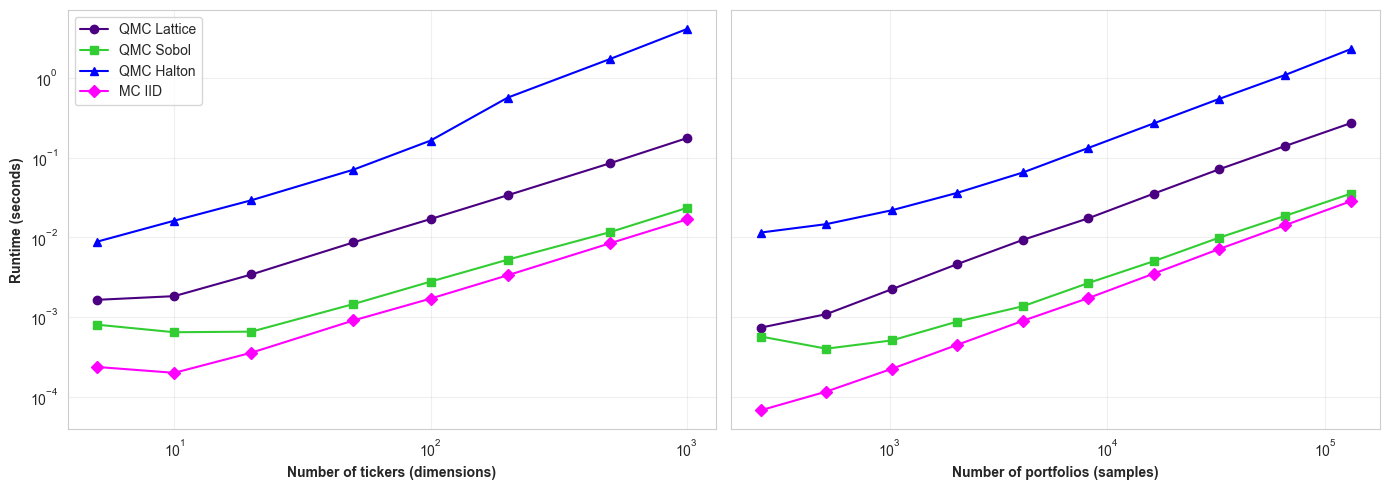

In [20]:
plot_runtime(df_runtime)

## CPU time

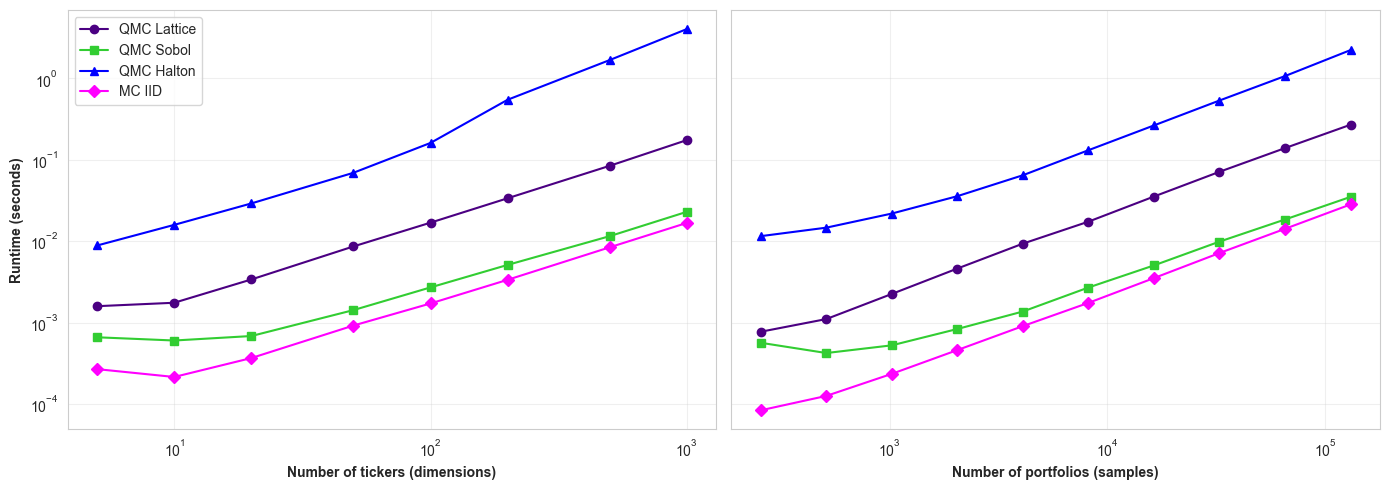

In [21]:
plot_runtime(df_runtime, runtime_type = 'Runtime_CPU')

## Backtesting 

*Backtesting* is a method used to retrospectively evaluate the the effectiveness of a strategy by simulating its performance using historical data.

In this section, we backtest the portfolios constructed from the optimal weights
identified by each sampling method. For each sampler type and risk level
(low, medium, and high), we compute portfolio values over time using historical
price data and average the results across replications.


In [22]:
def setup_stock_dfs(df, tickers):
    """Convert ticker data to indexed stock dataframes with normalized returns"""
    dfs = {}
    for ticker in tickers:
        stock_df = df[df['Ticker'] == ticker].reset_index().set_index('Date')
        stock_df['Norm Return'] = stock_df['Adj Close Price'] / stock_df.iloc[0]['Adj Close Price']
        dfs[ticker] = stock_df
    return dfs

In [27]:
df = pd.read_csv("data/df_2014-01-01_to_2025-12-13.csv", parse_dates=['Date'])

stocks = setup_stock_dfs(df, tickers)
aapl, amzn, csco, ibm = stocks['AAPL'], stocks['AMZN'], stocks['CSCO'], stocks['IBM']

In [28]:
principal = 10000 # starting investment value
num_ports = 2**14  # 16384 portfolios
risk_level = "high"
replications = 5

# Generate weights and compute Sharpe ratios for all samplers
w_lattice = gen_weights_reps('lattice', 4, num_ports, replications)
sr_lattice = sharpe_reps(w_lattice, lr)

w_sobol = gen_weights_reps('sobol', 4, num_ports, replications)
sr_sobol = sharpe_reps(w_sobol, lr)

w_halton = gen_weights_reps('halton', 4, num_ports, replications)
sr_halton = sharpe_reps(w_halton, lr)

w_iid = gen_weights_reps('iid', 4, num_ports, replications)
sr_iid = sharpe_reps(w_iid, lr)

### Portfolio performance for all sampling methods
We compute portfolio values using weights from all four sampling methods: Lattice, Sobol, Halton (QMC), and IID (MC).

In [29]:
# Compute portfolio values for all sampling methods
def compute_portfolio_value_reps(stock_dfs, weights_reps, principal):
 
    R, D = weights_reps.shape
    portfolios = []

    for r in range(R):
        positions = []
        for stock_df, alloc in zip(stock_dfs, weights_reps[r]):
            positions.append(stock_df['Norm Return'] * alloc * principal)
        portfolios.append(pd.concat(positions, axis=1).sum(axis=1))
    total = pd.concat(portfolios, axis=1)
    return total

def compute_all_portfolios(stocks, sr_dict, risk_levels, principal):
    """Compute portfolio values for all samplers and risk levels."""
    portfolios = {}
    for sampler, sr in sr_dict.items():
        portfolios[sampler] = {}
        for risk in risk_levels:
            weights_reps = sr[risk]   
            portfolios[sampler][risk] = compute_portfolio_value_reps(stocks, weights_reps, principal)
    return portfolios

# Get stock dataframes as tuple (for compute_portfolio_value)
stocks = (aapl, amzn, csco, ibm)

# Create SR dict for compute_all_portfolios
sr_dict = {
    'Lattice': sr_lattice,
    'Sobol': sr_sobol,
    'Halton': sr_halton,
    'IID': sr_iid
}

# Compute portfolio values using new consolidated function
all_portfolios_dict = compute_all_portfolios(stocks, sr_dict, ['low', 'medium', 'high'], principal)

# For display, compute high-risk portfolios (backward compatibility)
portf_lattice = all_portfolios_dict['Lattice']['high']
portf_sobol = all_portfolios_dict['Sobol']['high']
portf_halton = all_portfolios_dict['Halton']['high']
portf_iid = all_portfolios_dict['IID']['high']

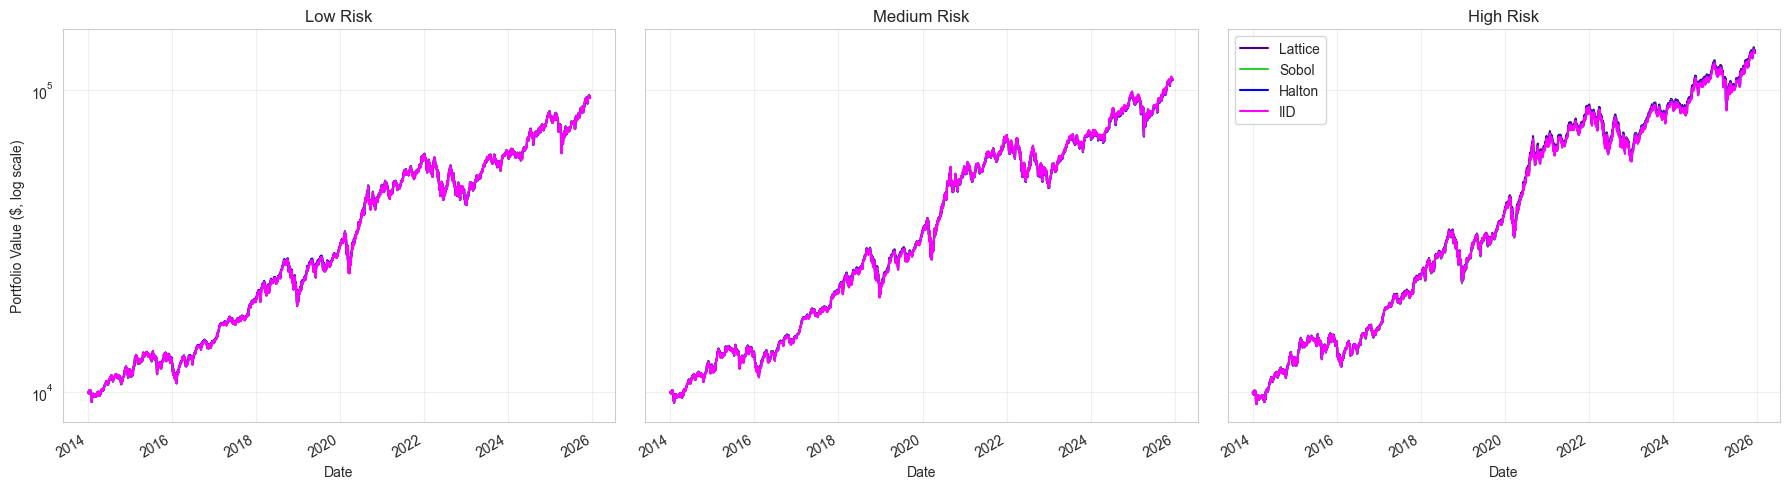

In [30]:
# Plot averaged portfolio values for all sampling methods across risk levels
colors = ['indigo', 'limegreen', 'blue', 'magenta']
risk_levels = ['low', 'medium', 'high']

fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

for idx, risk in enumerate(risk_levels):
    # Average across replications (axis=1 = time)
    portf_data = pd.DataFrame({
        sampler: all_portfolios_dict[sampler][risk].mean(axis=1)
        for sampler in sr_dict.keys()
    })

    portf_data.plot(
        ax=axes[idx],
        logy=True,
        linewidth=1.5,
        color=colors,
        legend=(idx == 2)
    )

    axes[idx].set_title(f'{risk.capitalize()} Risk', fontsize=12)
    axes[idx].set_xlabel('Date')

    if idx == 0:
        axes[idx].set_ylabel('Portfolio Value ($, log scale)')

plt.tight_layout()  

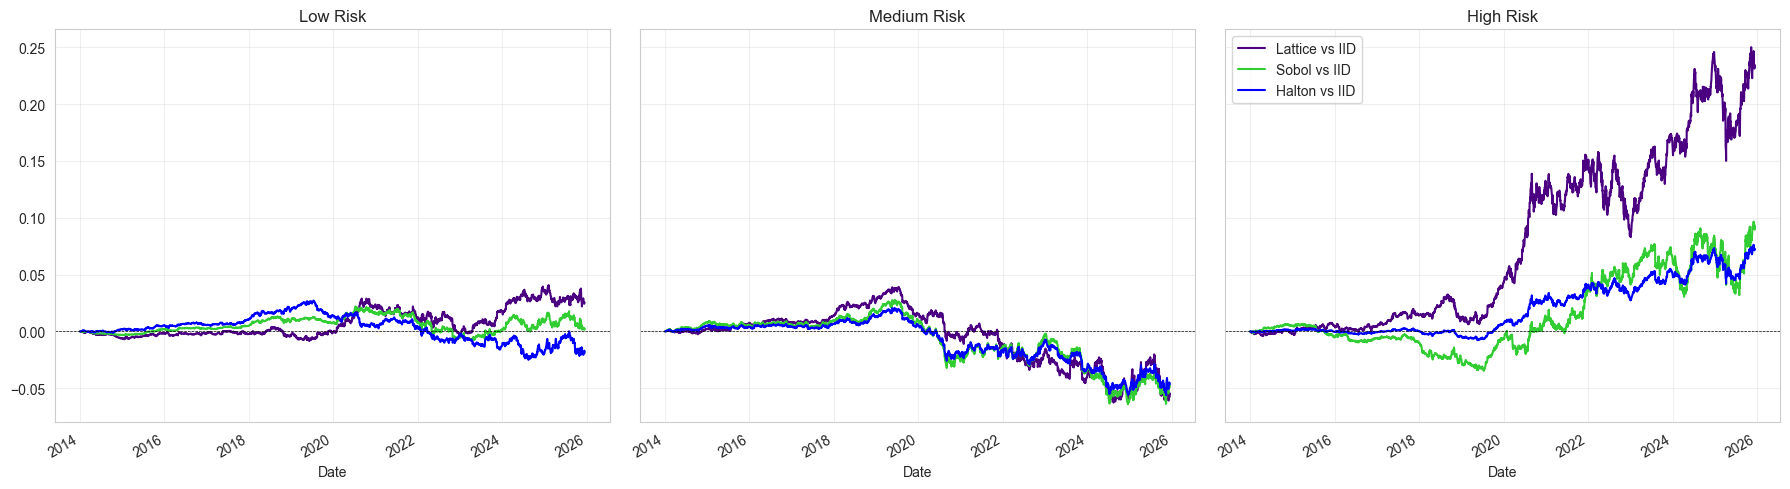

In [31]:
colors_diff = ['indigo', 'limegreen', 'blue']
risk_levels = ['low', 'medium', 'high']
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

for idx, risk in enumerate(risk_levels):
    diff_data = pd.DataFrame({
        'Lattice vs IID':
            (all_portfolios_dict['Lattice'][risk]
             - all_portfolios_dict['IID'][risk]).mean(axis=1) / principal,

        'Sobol vs IID':
            (all_portfolios_dict['Sobol'][risk]
             - all_portfolios_dict['IID'][risk]).mean(axis=1) / principal,

        'Halton vs IID':
            (all_portfolios_dict['Halton'][risk]
             - all_portfolios_dict['IID'][risk]).mean(axis=1) / principal,
    })

    diff_data.plot(
        ax=axes[idx],
        linewidth=1.5,
        color=colors_diff,
        legend=(idx == 2)
    )

    axes[idx].axhline(0, color='black', linestyle='--', linewidth=0.5)
    axes[idx].set_title(f'{risk.capitalize()} Risk', fontsize=12)
    axes[idx].set_xlabel('Date')

plt.tight_layout()
plt.show()

In [32]:
n_tickers = len(tickers1)   
num_ports = 2**14 # 16384 portfolios
principal = 10000 # starting investment value
replications = 5
lr1 = lr1.iloc[:,:n_tickers]

# generate weights and compute Sharpe ratios for all samplers
w_lattice = gen_weights_reps('lattice', n_tickers, num_ports, replications)
sr_lattice = sharpe_reps(w_lattice, lr1)

w_sobol = gen_weights_reps('sobol', n_tickers, num_ports, replications)
sr_sobol = sharpe_reps(w_sobol, lr1)

w_halton = gen_weights_reps('halton', n_tickers, num_ports, replications)
sr_halton = sharpe_reps(w_halton, lr1)

w_iid = gen_weights_reps('iid', n_tickers, num_ports, replications)
sr_iid = sharpe_reps(w_iid, lr1)

In [33]:
# 10 assets
df1 = pd.read_csv("data/df10_2014-01-01_to_2025-12-13.csv", parse_dates=['Date'])
stocks_dict = setup_stock_dfs(df1, tickers1)
stocks = tuple(stocks_dict[t] for t in tickers1)

# Create SR dict for compute_all_portfolios
sr_dict = {
    'Lattice': sr_lattice,
    'Sobol':   sr_sobol,
    'Halton':  sr_halton,
    'IID':     sr_iid
}

# Compute portfolio values 
all_portfolios_dict = compute_all_portfolios(stocks, sr_dict, ['low', 'medium', 'high'], principal)

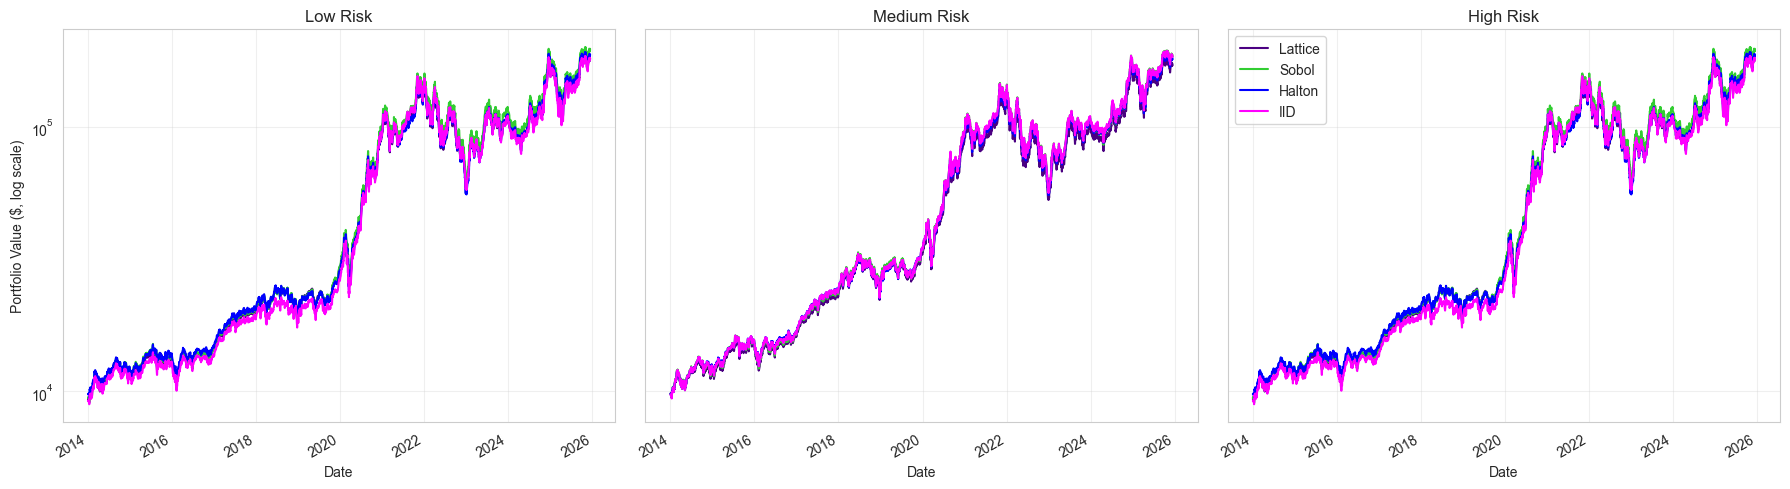

In [34]:
colors = ['indigo', 'limegreen', 'blue', 'magenta']
risk_levels = ['low', 'medium', 'high']

fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

for idx, risk in enumerate(risk_levels):
    # Average across replications
    portf_data = pd.DataFrame({
        sampler: all_portfolios_dict[sampler][risk].mean(axis=1)
        for sampler in sr_dict.keys()
    })

    portf_data.plot(
        ax=axes[idx],
        logy=True,
        linewidth=1.5,
        color=colors,
        legend=(idx == 2)
    )

    axes[idx].set_title(f'{risk.capitalize()} Risk', fontsize=12)
    axes[idx].set_xlabel('Date')

    if idx == 0:
        axes[idx].set_ylabel('Portfolio Value ($, log scale)')

plt.tight_layout()
plt.show()

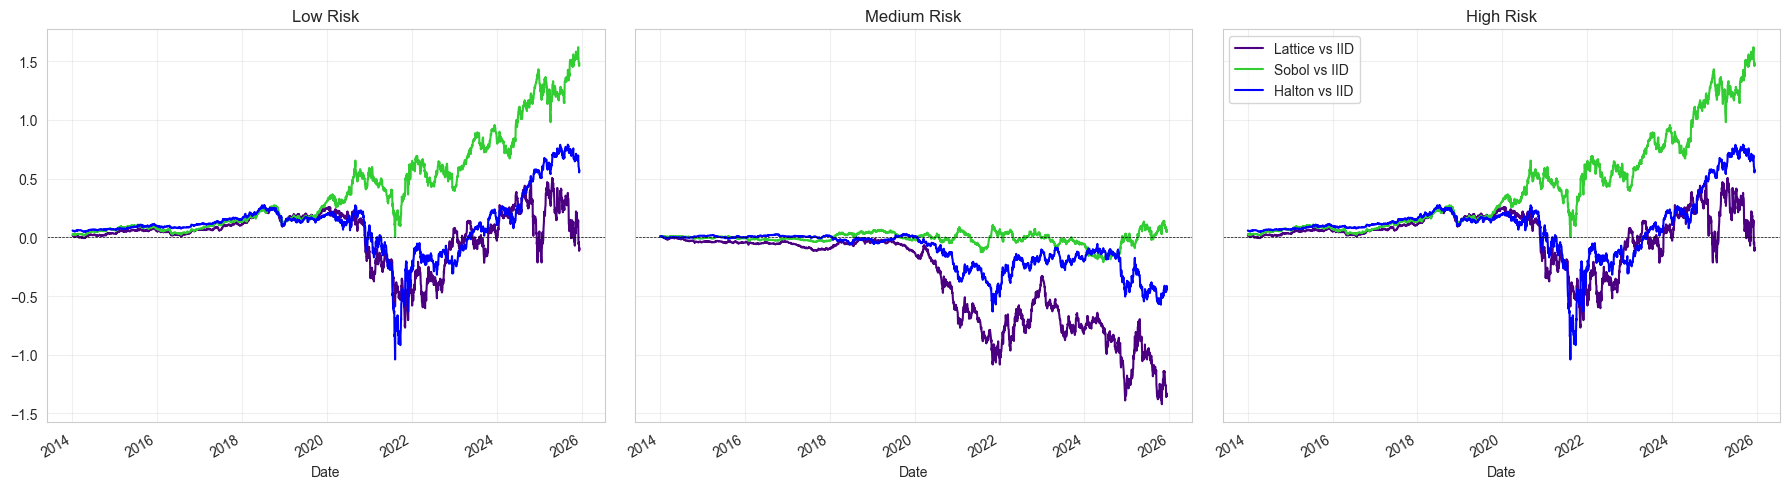

In [35]:
# Plot differences between QMC methods and MC IID for all risk levels
colors_diff = ['indigo', 'limegreen', 'blue']
risk_levels = ['low', 'medium', 'high']
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

for idx, risk in enumerate(risk_levels):
    diff_data = pd.DataFrame({
        'Lattice vs IID':
            (all_portfolios_dict['Lattice'][risk] - all_portfolios_dict['IID'][risk]).mean(axis=1) / principal,

        'Sobol vs IID':
            (all_portfolios_dict['Sobol'][risk] - all_portfolios_dict['IID'][risk]).mean(axis=1) / principal,

        'Halton vs IID':
            (all_portfolios_dict['Halton'][risk] - all_portfolios_dict['IID'][risk]).mean(axis=1) / principal,
    })

    diff_data.plot(
        ax=axes[idx],
        linewidth=1.5,
        color=colors_diff,
        legend=(idx == 2)
    )

    axes[idx].axhline(0, color='black', linestyle='--', linewidth=0.5)
    axes[idx].set_title(f'{risk.capitalize()} Risk', fontsize=12)
    axes[idx].set_xlabel('Date')

plt.tight_layout()
plt.show()

### Out-of-sample backtesting

In [36]:
# "train" range to find optimal weights (in-sample)
start_date = '2014-01-01'
train_end_date = '2021-12-31' 

# "test range" to evaluate portfolios using weigths obtained earlier (out-of-sample)
test_start_date = '2022-01-01'
end_date = '2025-12-13'

train_df = df[(df['Date'] >= start_date) & (df['Date'] <= train_end_date)]
test_df = df[(df['Date'] >= test_start_date) & (df['Date'] <= end_date)]

lr_train = lr.loc[start_date:train_end_date]

In [37]:
stocks = setup_stock_dfs(test_df, tickers)
aapl, amzn, csco, ibm = stocks['AAPL'], stocks['AMZN'], stocks['CSCO'], stocks['IBM']

In [38]:
principal = 10000 # starting investment value
num_ports = 2**14  # 16384 portfolios
risk_level = "high"
replications = 30

# Generate weights and compute Sharpe ratios for all samplers
w_lattice = gen_weights_reps('lattice', 4, num_ports, replications)
sr_lattice = sharpe_reps(w_lattice, lr_train)

w_sobol = gen_weights_reps('sobol', 4, num_ports, replications)
sr_sobol = sharpe_reps(w_sobol, lr_train)

w_halton = gen_weights_reps('halton', 4, num_ports, replications)
sr_halton = sharpe_reps(w_halton, lr_train)

w_iid = gen_weights_reps('iid', 4, num_ports, replications)
sr_iid = sharpe_reps(w_iid, lr_train)

In [39]:
stocks = (aapl, amzn, csco, ibm)

# Create SR dict for compute_all_portfolios
sr_dict = {
    'Lattice': sr_lattice,
    'Sobol': sr_sobol,
    'Halton': sr_halton,
    'IID': sr_iid
}

# Compute portfolio values using new consolidated function
all_portfolios_dict = compute_all_portfolios(stocks, sr_dict, ['low', 'medium', 'high'], principal)

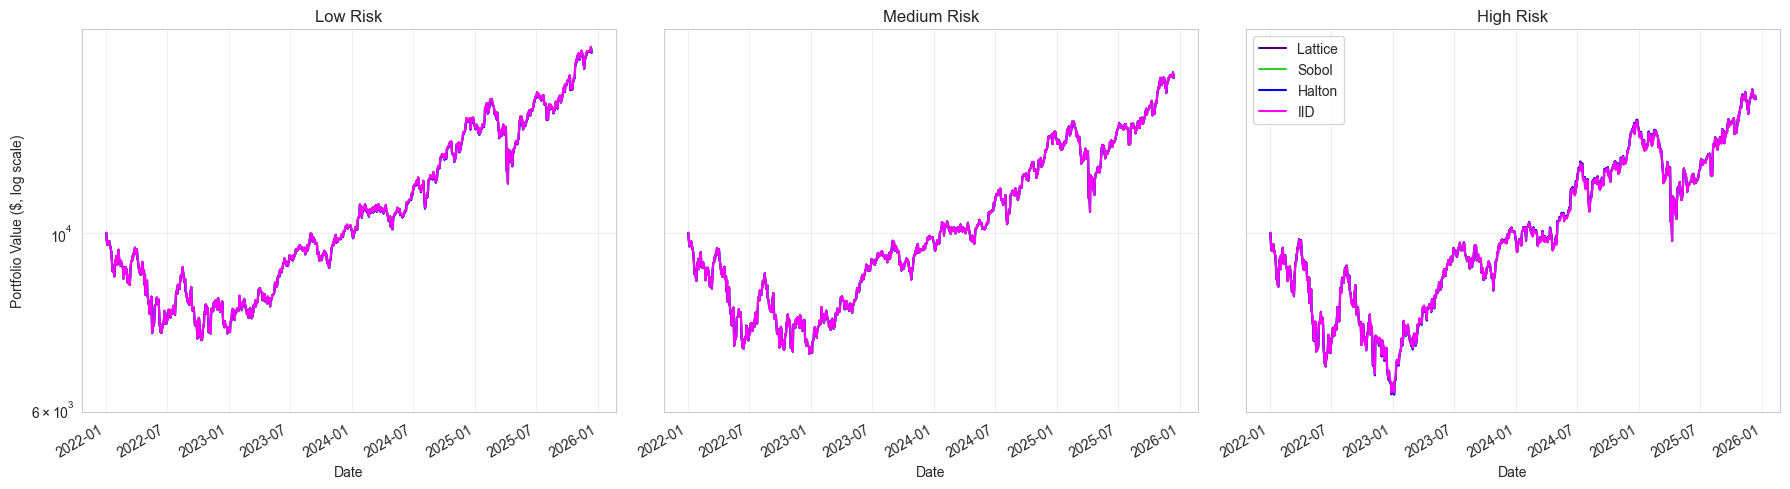

In [40]:
# Plot averaged portfolio values for all sampling methods across risk levels
colors = ['indigo', 'limegreen', 'blue', 'magenta']
risk_levels = ['low', 'medium', 'high']

fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

for idx, risk in enumerate(risk_levels):
    # Average across replications (axis=1 = time)
    portf_data = pd.DataFrame({
        sampler: all_portfolios_dict[sampler][risk].mean(axis=1)
        for sampler in sr_dict.keys()
    })

    portf_data.plot(
        ax=axes[idx],
        logy=True,
        linewidth=1.5,
        color=colors,
        legend=(idx == 2)
    )

    axes[idx].set_title(f'{risk.capitalize()} Risk', fontsize=12)
    axes[idx].set_xlabel('Date')

    if idx == 0:
        axes[idx].set_ylabel('Portfolio Value ($, log scale)')

plt.tight_layout()  

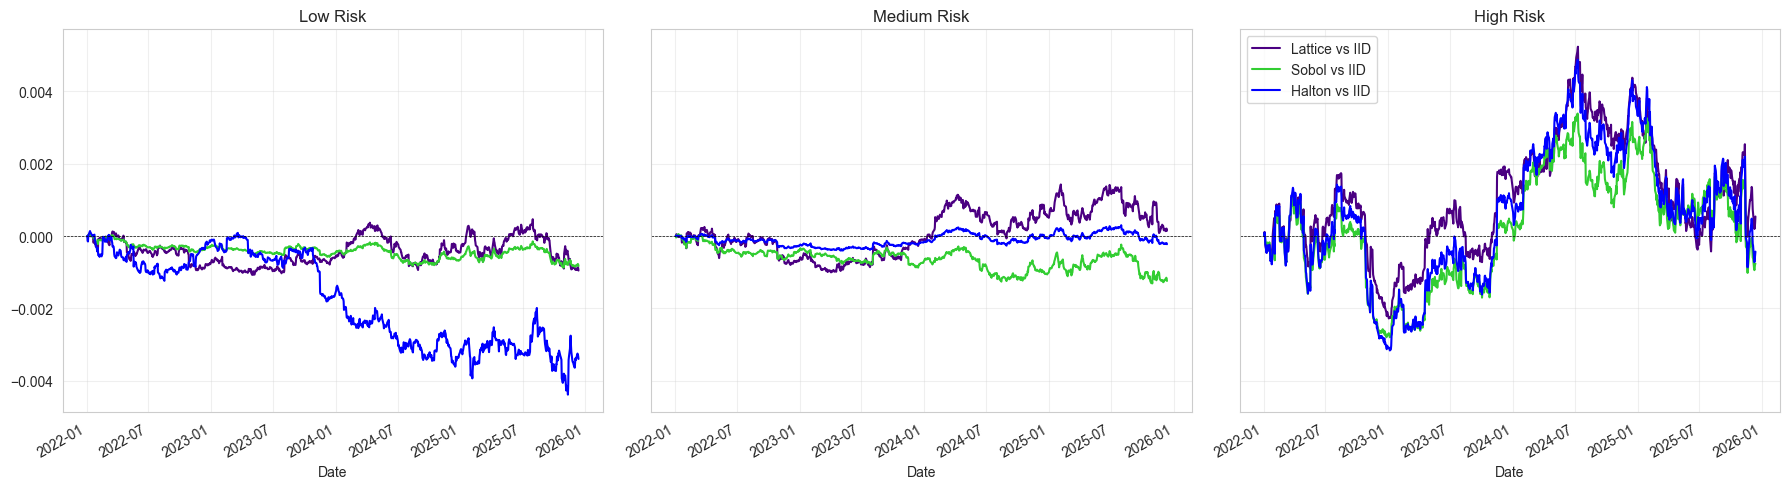

In [41]:
colors_diff = ['indigo', 'limegreen', 'blue']
risk_levels = ['low', 'medium', 'high']
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

for idx, risk in enumerate(risk_levels):
    diff_data = pd.DataFrame({
        'Lattice vs IID':
            (all_portfolios_dict['Lattice'][risk]
             - all_portfolios_dict['IID'][risk]).mean(axis=1) / principal,

        'Sobol vs IID':
            (all_portfolios_dict['Sobol'][risk]
             - all_portfolios_dict['IID'][risk]).mean(axis=1) / principal,

        'Halton vs IID':
            (all_portfolios_dict['Halton'][risk]
             - all_portfolios_dict['IID'][risk]).mean(axis=1) / principal,
    })

    diff_data.plot(
        ax=axes[idx],
        linewidth=1.5,
        color=colors_diff,
        legend=(idx == 2)
    )

    axes[idx].axhline(0, color='black', linestyle='--', linewidth=0.5)
    axes[idx].set_title(f'{risk.capitalize()} Risk', fontsize=12)
    axes[idx].set_xlabel('Date')

plt.tight_layout()
plt.show()

# References

1. **QMCPy**: Choi, S.-C. T., Hickernell, F. J., McCourt, M., Rathinavel, J., & Sorokin, A. (2020). QMCPy: A quasi-Monte Carlo Python library. https://qmcpy.org/

2. **Sharpe Ratio**: Sharpe, W. F. (1966). Mutual fund performance. *Journal of Business*, 39(1), 119-138.

3. **Low-Discrepancy Sequences**: Niederreiter, H. (1992). *Random Number Generation and Quasi-Monte Carlo Methods*. SIAM.

4. **Lattice Rules**: Sloan, I. H., & Joe, S. (1994). *Lattice Methods for Multiple Integration*. Oxford University Press.

5. **Sobol Sequences**: Sobol', I. M. (1967). On the distribution of points in a cube and the approximate evaluation of integrals. *USSR Computational Mathematics and Mathematical Physics*, 7(4), 86-112.

6. **Portfolio Theory**: Markowitz, H. (1952). Portfolio selection. *Journal of Finance*, 7(1), 77-91.

7. **Simplex Transformation for Low-Discrepany Sequences (1)** : Pillards, T., & Cools, R. (2005). Transforming low-discrepancy sequences from a cube to a simplex. *Journal of Computational and Applied Mathematics*, 174(1), 29–42. 

8. **Simplex Transformation for Low-Discrepany Sequences (2)** : Basu, K., & Owen, A. B. (2016). Transformations and Hardy–Krause variation. *SIAM Journal on Numerical Analysis*, 54(3), 1946–1966.

